## Milestone

Handwriting to LaTeX<br>

Adam Jensen, Henrik Marklund<br>
oojensen@stanford.edu, marklund@stanford.edu<br>

### Background
We were typing up our CS229 homework and realized that we were spending more time on LaTeX than the actual homework. We did a quick informal survey amongst students in the Huang basement who concurred: yes, typesetting is a major inconvenience! Many said they spent over 5 and 10 hours per homework in CS221 and CS229 respectively. Another typical response was: “I chose not to typeset on the last CS229 homework, as I did not have time”.<br>

There is currently no good solution for converting handwritten notes into LateX. As a consequence, STEM students around the world struggle. The long term goal is to train an algorithm that takes a scan of your a4 page and turns it into latex typesetting. <br>

We limit the scope of this project, by having two aims:<br>
1. Create a seq-to-seq model with attention turning images of digital equations into latex. <br>
2. Train this model on handwritten equations (augmented data) and investigate its effectiveness.<br>

The first goal is a request-for-research at OpenAI: https://openai.com/requests-for-research/#im2latex 


### Dataset
Harvard Researchers have crawled wikipedia for mathematical equations and gathered a 100k equations from which one can generate images. Dataset: Harvard im-to-latex-100k (Described in __[Deng et al., 2016](https://arxiv.org/pdf/1609.04938.pdf)__) Guilluame Genthial at Stanford was kind enough to send us his generated images (as this takes quite some time). We do some additional processing (padding, and additional downsampling).

Here is an example image with corresponding latex:

<img src="model_visualizations/example_image.png" height="30%" width="30%" alt="Learning rate schedule" title="Learning rate" />

__Latex__:
\widetilde \gamma \_ { \mathrm { h o p f } } \simeq \sum \_ { n > 0 } \widetilde { G } \_ { n } { \frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } }

##### Histogram: Sequence lengths
<img src="model_visualizations/sequence_lengths.jpg" height="35%" width="35%" alt="Learning rate schedule" title="Learning rate" />

When running the code you will see more examples and more details about the dataset.

### Progress (sequential):

__1. Dataset loaded and processed.__ <br>
We have approx 80k images with corresponding latex loaded and preprocessed. For now we skip looking at too long sentences and too big images.<br><br>
__2. Encoder-Decoder model up and running.__ <br>
Our model is based on a typical seq-to-seq model for translation. We started out with a seq-to-seq model for translation in Keras using LSTM (__[Described by Francois Chollet](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)__. We replaced the encoder with a convolution neural network as described by in the paper __[Image to Latex by Genthial & Sauvestre (2016)](http://cs231n.stanford.edu/reports/2017/pdfs/815.pdf)__. The conv. network design is one of the versions __[here](https://github.com/guillaumegenthial/im2latex/blob/master/model/encoder.py)__. We have one model for training and one model for inference (using the weights from the first model). Pictures of the models are below.<br><br>
__3. Overfit to 10 examples__<br>
After introducing Batch Normalization we managed to overfit to 10 examples. Still hard to overfit to many more examples. Could be that we need to train for a lot longer. When we do inference it seems to have learned a few different equations that it chooses among. As you'll see when you do inference with pretrained weights on the 40k images, it seems to choose from a set of equations that it predicts over and over.<br><br>
__4. Training with decreasing loss on 40k images / sequences__ <br>
Training is really slow which makes it important that we are systematic and smart about our experiments going forward.
Implemented Clip Gradient and a Learning rate schedule.<br><br>
__5. For debugging: Created an analogous but less complex problem.__ <br>
Since it was hard to know why it was so hard overfitting to a larger number of examples we created a simpler but analogous problem: turning pictures of text into text (but treating each character as a separate token to keep the problem analogous). Training was a lot easier, and we could much more easily overfit on a larger number training examples.


### Training on 60k images
We have only tried training the whole dataset for a longer period of time once (Currently running, 12 hours on CPU so far). We have waited with this because we’ve not been able to overfit on 100 examples. The reason we don’t overfit on 100 example could be that we just have not trained for long enough.

Anyhow, below is our training and validation loss. We categorical cross entropy loss and forced teaching in our model.

 | \-    | Train error | Val error | Learning rate |
|-----------------|-------------|-----------|---------------|
| Start           | 3.64        | NA        | \-            |
| Epoch 1         | 1.44        | 1.30      | 0.004         |
| Epoch 2         | 1.13        | 1.17      | 0.004         |
| Epoch 3         | 1.04        | 1.09      | 0.004         |
| Epoch 4         | 0.96        | 1.05      | 0.0014        |
| Epoch 5         | 0.92        | 1.00      | 0.0011        |
| Epoch 6 (1 / 5) | 0.89        | NA        | 0.0009        |


Losses for each batch is not included here (We have noticed that when training, the loss goes down a lot in the beginning of the epoch and the doesn’t get much lower than this during the epoch (goes up a bit). This has been true of all epochs so far.

###### Learning rate schedule
We implement a learning rate schedule with callbacks in Keras to have more control and oversight over what’s happening with the learning rate. This is the current learning rate schedule:


<img src="model_visualizations/learning_rate_schedule.jpg" height="40%" width="40%" alt="Learning rate schedule" title="Learning rate" />



### Going forward

__Step 1: Find out why we have a hard time overfitting to 100 examples.__
- Implement function to retrieve gradient norms
- We have had problems with Keras trying to do this.
- Train for a longer time (10 hours) and logg everything.
- Try diagnosing the problem better.
- Train using Embedding of token.
We have already code written for this but have not tried training for a longer period of time. Genthail suggests initializing with orthogonal matrices helped training a lot.
- Systematically experiment with different learning schedules: learning rates and decay

__Step 2: Implement beam search to improve Inference__
- We’ve begun this work.
- This has had a huge impact in previous work (and does not affect training)

__Step 3: Implement Attention__
- This also has had a huge impact in previous work.
- May make training difficult (according to previous papers)
- OpenAI recommends trying it on a toy problem of long sequences of MNIST characters to make sure the model “is not badly broken”.

__Step 4: Implement better evaluation metrics__

__Step 5 (when better accuracy): Train on handwriting__
- Train on CHORHME dataset
- Generate synthetic handwriting (using Chrome-dataset or Detexify)


### The models

#### Training: Encoder - Decoder

<img src="model_visualizations/training_model.png" height="20%" width="70%" alt="Training model" title="Training model" />

#### Inference: Encoder
The first part in the picture above. The main difference during inference is that we don't feed the correct tokens as inputs to the LSTM (forced teaching). Instead we feed the prediction of the decoder to the LSTM for it to produce the next token.


#### Inference: Decoder

<img src="model_visualizations/inference_decoder_model.png" height="40%" width="70%" alt="Training model" title="Training model" />


### Try it out

We've cleaned up the code somewhat to only show you what is actually in use. You will find more details about the dataset as you run the code. Happy training!

1. Make sure you have /data folder
2. Make sure you have the /checkpoints folder


In [5]:
#Import Numpy, Tensorflow and Keras
import numpy as np
import tensorflow as tf
import math
import cv2

from tensor2tensor.layers.common_attention import add_timing_signal_nd #currently not in use

from keras.layers import Input, LSTM, Dense, Lambda, GlobalAveragePooling1D
from keras.layers import Convolution2D, MaxPooling2D, Reshape, Flatten, BatchNormalization, Embedding
from keras import layers, backend ## IS THIS BEING USED?
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, Callback
import keras.backend as K
from keras import optimizers, metrics

from keras.utils import plot_model
from IPython.display import Image

from matplotlib import pyplot as plt

# Import our own helper functions
from prepare_data import get_decoder_data, get_decoder_data_int_sequences



In [11]:
## This cell contains a bunch of functions for loading and preprocessing the data

def get_max_shape(images):

	max_height = 0
	max_width = 0

	for image in images:

		if image.shape[0] > max_height:
			max_height = image.shape[0]

		if image.shape[1] > max_width:
			max_width = image.shape[1]


	return [max_height, max_width]


def normalize_images(images):

	images = images.astype(np.float32)
	images = np.multiply(images, 1.0 / 255.0)

	return images

def down_sample(images, factor): 
	target_h = int(math.floor(float(images[0].shape[0]) * factor))
	target_w = int(math.floor(float(images[0].shape[1]) * factor))
	num_images = len(images)
	down_sampled_images = np.ones((num_images, target_h, target_w)) * 255

	for idx, image in enumerate(images):
		
		im = image

		#Downsample
		im = cv2.resize(im, (0, 0), fx = factor, fy=factor, interpolation = cv2.INTER_AREA) #cv2.INTER_LINEAR


		down_sampled_images[idx, :, :] = im

	return down_sampled_images


def down_sample_flexible(images, factor): 
    print("downsampling images")
    new_images = []

    for image in images:
        new_image = cv2.resize(image, (0, 0), fx = factor, fy=factor, interpolation = cv2.INTER_AREA) #cv2.INTER_LINEAR
        new_images.append(new_image)

    return new_images


def pad_images(images, target_shape = None):
	print(images[0])

	if (target_shape == None):
		max_height, max_width = get_max_shape(images)

	num_images = len(images)

	padded_images = np.ones((num_images, max_height, max_width)) * 255

	for idx, image in enumerate(images):

		h = image.shape[0]
		w = image.shape[1]

		padded_images[idx, :h, :w] = image


	return padded_images

def get_vocabulary_size():
    return len(get_vocabulary())

def get_vocabulary(dataset):
    if dataset == "small":
        vocab = [line for line in open('data/tin/tiny_vocab.txt')]
    elif dataset == "test":
        vocab = [line for line in open('data/vocab.txt')]
    elif dataset == "train":
        vocab = [line for line in open('data/vocab.txt')]

    vocab = [x.strip('\n') for x in vocab]
    return vocab

def load_raw_data(dataset, max_token_length = 400, max_image_size = (60, 200), max_num_samples = 5000):

    
    token_vocabulary = []
    token_sequences = []
    images = []
    
    if dataset == "small":
        image_folder = 'data/tin/tiny/'
        formula_file_path = "data/tin/tiny.formulas.norm.txt"
    elif dataset == "test":
        image_folder = 'data/images_test/'
        formula_file_path = "data/test.formulas.norm.txt"
    elif dataset == "train":
        image_folder = 'data/images_train/'
        formula_file_path = "data/train.formulas.norm.txt"


        
    included_counter = 0
    examples_counter = 0
    with open (formula_file_path, "r") as myfile:

        for idx, token_sequence in enumerate(myfile):
            examples_counter += 1
            #Check token size:
            token_sequence = token_sequence.rstrip('\n')
            tokens = token_sequence.split()

            file_name = str(idx) + '.png'
            image = cv2.imread(image_folder + file_name, 0)
            
            if image is None:
                print("Not loading image with id:", idx)
                continue
            
            #print(tokens)
            if len(tokens) <= max_token_length and image.shape[0] <= max_image_size[0] and image.shape[1] <= max_image_size[1]:
                token_sequences.append('**start** ' + token_sequence + ' **end**')
                #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Grey scale
                #print(image)
                
                images.append(image)
                for token in tokens:
                    if token not in token_vocabulary:
                        token_vocabulary.append(token)

                included_counter += 1
                if included_counter == max_num_samples:
                    break

        
    token_vocabulary.append("**start**")
    token_vocabulary.append("**end**")
    
    return images, token_sequences, token_vocabulary


def preprocess_images(images):

    down_sample_factor = 0.7
    encoder_input = down_sample_flexible(images, 0.6)
    encoder_input = pad_images(encoder_input)
    encoder_input = normalize_images(encoder_input)

    # Add dimension for TensorFlow Conv Layers to work properly as it needs (None, Height, Width, 1)
    encoder_input = encoder_input.reshape(encoder_input.shape[0], encoder_input.shape[1], encoder_input.shape[2], 1)

    return encoder_input


def load_data(dataset, max_token_length, max_image_size, max_num_samples):

    if (dataset == "small"):
        images, token_sequences, token_vocabulary = load_raw_data(dataset="small", max_num_samples=max_num_samples)
        images = preprocess_images(images)
    elif (dataset == "test"):
        images, token_sequences, token_vocabulary = load_raw_data(dataset="test",  max_token_length = max_token_length, max_image_size = max_image_size, max_num_samples=max_num_samples)
        images = preprocess_images(images)
    elif (dataset == "train"):
        images, token_sequences, token_vocabulary = load_raw_data(dataset="train",  max_token_length = max_token_length, max_image_size = max_image_size, max_num_samples=max_num_samples)
        images = preprocess_images(images)
    return images, token_sequences, token_vocabulary

Text(0.5,1,u'Histogram: Sequence lengths')

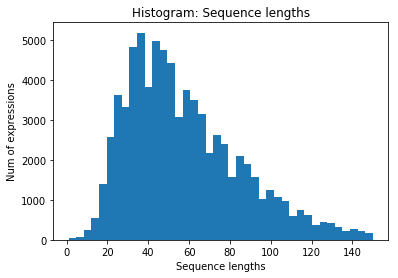

In [8]:
## Make a histogram of how long the sequences are
## Helps us decide on a cut off point

formula_file_path = "data/train.formulas.norm.txt"

formula_lengths = []

with open (formula_file_path, "r") as myfile:
    for idx, token_sequence in enumerate(myfile):
        tokens = token_sequence.split()
        formula_lengths.append(len(tokens))

%matplotlib inline

plt.hist(formula_lengths, normed=False, bins=40)
plt.ylabel('Num of expressions');
plt.xlabel('Sequence lengths')
plt.title('Histogram: Sequence lengths')

In [9]:
## Load and process data (takes a up to 10 minutes)

max_token_length = 70
max_image_size = (60, 270)
max_num_samples = 70000
encoder_input_data, target_texts, token_vocabulary = load_data(dataset="train", 
                                                               max_token_length=max_token_length,
                                                               max_image_size=max_image_size,
                                                               max_num_samples=max_num_samples)

target_tokens = token_vocabulary


## Note: Approx 15 images are missing and will not be loaded.

('Not loading image with id:', 2622)
('Not loading image with id:', 8140)
('Not loading image with id:', 14140)
('Not loading image with id:', 17337)
('Not loading image with id:', 23305)
('Not loading image with id:', 27738)
('Not loading image with id:', 29229)
('Not loading image with id:', 39602)
('Not loading image with id:', 42008)
('Not loading image with id:', 49252)
('Not loading image with id:', 49445)
('Not loading image with id:', 55767)
('Not loading image with id:', 63914)
('Not loading image with id:', 64058)
('Not loading image with id:', 64336)
('Not loading image with id:', 64600)
('Not loading image with id:', 66155)
('Not loading image with id:', 71501)
downsampling images
[[255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 ..., 
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]]
Getting max shape


In [15]:
# Let's check the data out:

num_decoder_tokens = len(target_tokens)

max_decoder_seq_length = max([len(txt.split()) for txt in target_texts])

target_token_index = dict(
    [(token, i) for i, token in enumerate(target_tokens)])

reverse_target_token_index = dict(
    (i, char) for char, i in target_token_index.items()) ## Will be used in the inference model

print("Maximum output sequence lenght: " + str(max_decoder_seq_length) + "\n")
print("Examples of sequences: ")
print("Ex. 1: " + str(target_texts[0]) + "\n")
print("Ex. 1: " + str(target_texts[1]) + "\n \n")

print("Number of examples: " + str(len(encoder_input_data)))


print("Number of tokens in our vocabulary: " + str(num_decoder_tokens))
print("5 example of tokens: " + str(target_tokens[0:5]) + "\n")

print("\n Example pairs (token, index) in dictionary: ")

for i, key in enumerate(target_token_index):
    print(key, target_token_index[key])
    if i > 10:
        break

_, image_h, image_w, _  = encoder_input_data.shape

Maximum output sequence lenght: 72

Examples of sequences: 
Ex. 1: **start** \widetilde \gamma _ { \mathrm { h o p f } } \simeq \sum _ { n > 0 } \widetilde { G } _ { n } { \frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } } **end**

Ex. 1: **start** ( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \ \ ( { \cal L } _ { a } H ) _ { i j k } = 0 , **end**
 

Number of examples: 42508
Number of tokens in our vocabulary: 476
5 example of tokens: ['\\widetilde', '\\gamma', '_', '{', '\\mathrm']


 Example pairs (token, index) in dictionary: 
('\\perp', 228)
('\\leq', 246)
('\\begin{picture}', 325)
('\\supset', 256)
('\\protectm', 433)
('\\raisebox', 413)
('0', 14)
('\\Re', 369)
('\\smallint', 468)
('\\vspace', 95)
('\\hspace', 227)
('\\vert', 209)


In [16]:
# For forced teaching, we need decoder_input data and decoder target data. (takes a few minutes)
# Decoder target data is just decoder_input_data offset by one time step.

decoder_input_data, decoder_target_data = get_decoder_data(target_texts,
                                                            target_tokens,
														 	 num_decoder_tokens,
														 	  max_decoder_seq_length,
														 	   target_token_index)

print("Each row is a one-hot encoded token in the sequence.")
print("We have 10 columns because there are 10 tokens in our vocabulary")
print("We have 9 rows, because maximum output length is 9")
print("")

print("Decoder INPUT sequence example 1")
print(decoder_input_data[0]) #Each row is a one-hot encoded token in the sequence.
print("")
print("Decoder TARGET sequence example 1 (the same as above offset by one time step)")
print(decoder_target_data[0]) #Each row is a one-hot encoded token in the sequence.

Each row is a one-hot encoded token in the sequence.
We have 10 columns because there are 10 tokens in our vocabulary
We have 9 rows, because maximum output length is 9

Decoder INPUT sequence example 1
[[ 0.  0.  0. ...,  0.  1.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]

Decoder TARGET sequence example 1 (the same as above offset by one time step)
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


Latex: **start** \, ^ { * } d \, ^ { * } H = \kappa \, ^ { * } d \phi = J _ { B } . **end**


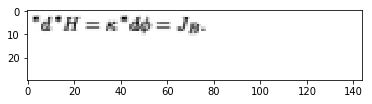

Latex: **start** \partial _ { \mu } ( F ^ { \mu \nu } - e j ^ { \mu } x ^ { \nu } ) = 0 . **end**


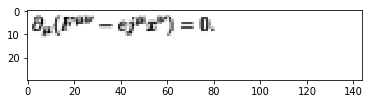

Latex: **start** \rho _ { L } ( q ) = \sum _ { m = 1 } ^ { L } \ P _ { L } ( m ) \ { \frac { 1 } { q ^ { m - 1 } } } \ \ . **end**


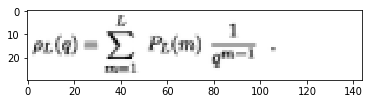

In [21]:
## Look at a few examples (we have downsampled them further from what is in the data folder):
## Note that we have added the "**start**" and "**end**" token to all sentences.

for i in range(3,6):

    print("Latex: " + (target_texts[i]))

    plt.imshow(encoder_input_data[i,:,:,0], cmap='gray')
    plt.show()



In [22]:
## Time to build our model: Image -> ConvNet Encoder -> LSTM Decoder --> Latex


## Encoder step I: Encoding image into vectors (e1, e2, ..., en)
## Convnet design from Guillaume Genthial https://github.com/guillaumegenthial/im2latex/blob/master/model/encoder.py

def get_encoded(image_h, image_w):

    encoder_inputs = Input(shape=(image_h, image_w,1), name="encoder_input_image", dtype='float32')

    # Conv + max_pool / 2
    encoded = Convolution2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(encoder_inputs)
    encoded = MaxPooling2D(pool_size=2, padding='same')(encoded)

    encoded = BatchNormalization()(encoded)
    # Conv + max_pool /2
    encoded = Convolution2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(encoded)
    encoded = MaxPooling2D(pool_size=2, padding='same')(encoded)

    encoded = BatchNormalization()(encoded)
    
    # 2 Conv
    encoded = Convolution2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(encoded)
    encoded = Convolution2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(encoded)
    
    # Pooling + Convnet + Pooling (Note pool_size)
    encoded = MaxPooling2D(pool_size=(2,1))(encoded)
    encoded = Convolution2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(encoded)
    encoded = MaxPooling2D(pool_size=(1,2))(encoded)
    
    # BatchNormalization, Convolution
    encoded = BatchNormalization()(encoded)
    encoded = Convolution2D(filters=512, kernel_size=(3,3), padding='valid', activation='relu')(encoded)

    #encoded = time_signal()(encoded)

    encoded_shape = encoded.get_shape().as_list()
    _, h, w, c = encoded_shape

    #Unroll the encoding to a series of vectors (e1, e2, e3..... en)
    encoded = Reshape((w*h, c), name="unroll_encoding")(encoded)
    
    return encoder_inputs, encoded

In [23]:
## Encoder step II: transforming (e1, e2... en) to h0 and c0 
# h0, and c0  will be the initial state of the decoder

# Call convolutional encoder
encoder_inputs, encoded = get_encoded(image_h, image_w)

encoded_shape = encoded.get_shape().as_list()

#Compute the average e from encoding.

e_average = GlobalAveragePooling1D(name='average_e')(encoded)

e_average = BatchNormalization()(e_average)

#Compute h0 and c0, from e_average, following Genthial's suggestion
h0 = Dense(512, activation='tanh', name="h0")(e_average)
c0 = Dense(512, activation='tanh', name="c0")(e_average)

h0 = BatchNormalization()(h0)
c0 = BatchNormalization()(c0)


In [27]:
## Decoder. LSTM + Softmax layer

decoder_lstm_dim = 512

# Training decoder
# Set up the decoder, using `encoder_states` as initial state.
#decoder_inputs = Input(shape=(max_decoder_seq_length, num_decoder_tokens), name='decoder_input_sequence')


# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.

    
decoder_inputs = Input(shape=(max_decoder_seq_length, num_decoder_tokens), name='decoder_input_sequence')

decoder_lstm = LSTM(decoder_lstm_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=[h0, c0])

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

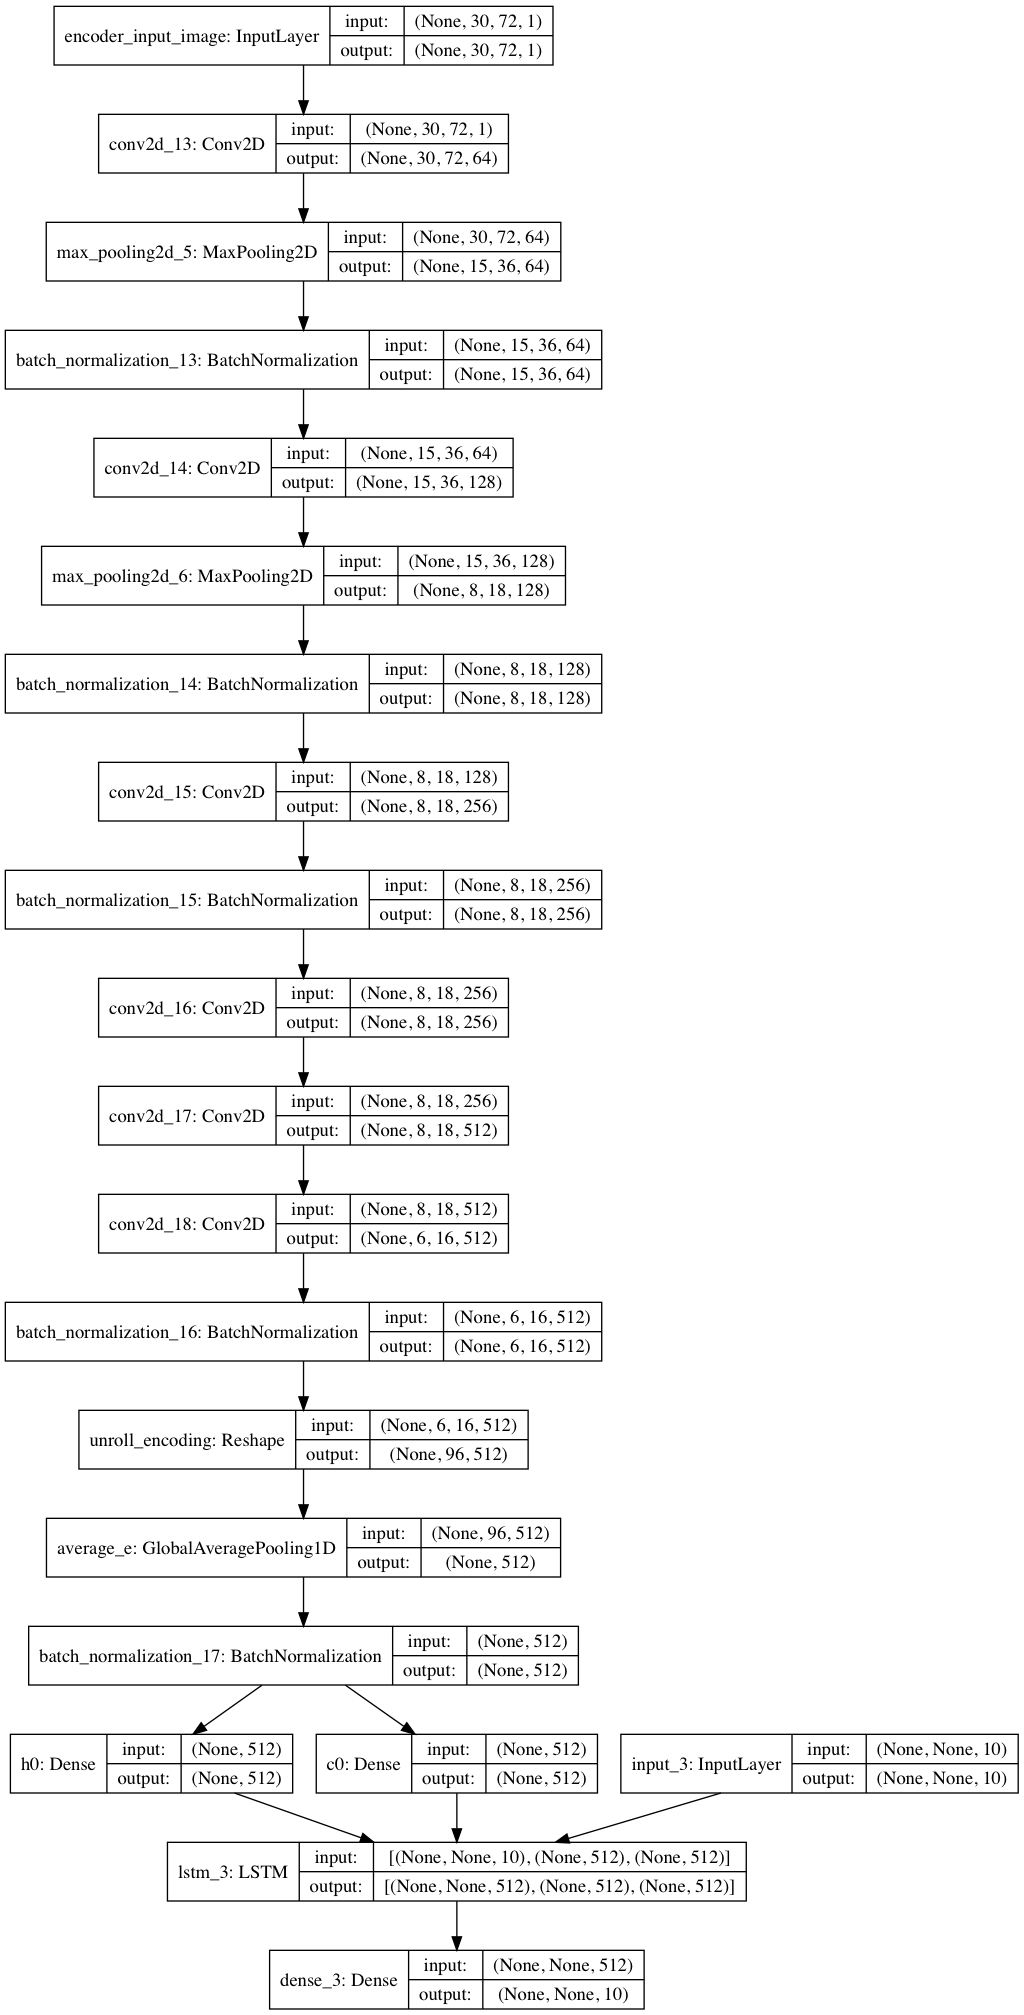

In [28]:
## Putting the training model together

model = Model(inputs=[encoder_inputs, decoder_inputs],outputs=decoder_outputs)

## Visualize the training model

plot_model(model, to_file='output/model_visualizations/training_model.png', show_shapes=True)

#Image(filename='training_model.png') 

In [33]:
# Callback to get losses for each batch (and not each epoch)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
loss_history = LossHistory()

In [34]:
# Optimizer

learning_rate = 0.001 # OBS: Learning rate is set with a callback instead (see next cell)
beta_1 = 0.9 # Keras default
beta_2 = 0.999 # Keras default
epsilon=1e-08 # Keras default
decay=0 # OBS: Decaying with a callback instead (see next cell)
clipvalue = 5 # 

adam_optimizer = optimizers.Adam(lr=learning_rate,
                                       beta_1=beta_1,
                                       beta_2=beta_2, 
                                       epsilon=epsilon,
                                       decay=decay,
                                        clipvalue=clipvalue)


In [35]:
# learning rate schedule (IN USE)
#def step_decay(epoch):
    
    #base_rate = 0.002
    #decay_rate = 0.4

    if epoch <= 2:
        lrate = 0.0005 #
    elif epoch <= 30:
        lrate = base_rate * 1. / (1 + (epoch - 2) * decay_rate) 
    else:
        lrate = 0.0001
       
    # Epoch 1-2: 0.004
    # Epoch 3: 0.0014
    # Epoch 6: 0.0007
    # Epoch 10: 0.0004
    # Epoch 20: 0.00024
    # Epoch 30: 0.00016 
        
    print("Learning rate: ", lrate)
    return lrate

lrate = LearningRateScheduler(step_decay)

In [ ]:
## Compile and train the model

# checkpoint
filepath="checkpoints/weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, period=2)

callbacks_list = [lrate, checkpoint, loss_history]

model.compile(adam_optimizer, loss='categorical_crossentropy')

epochs = 1
batch_size = 64

model_history = model.fit([encoder_input_data, decoder_input_data],
          decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.05,
         callbacks=callbacks_list)


In [ ]:
## Save the model

#model.save_weights("model.h5")

In [38]:
## NOTE:

### Uncomment to use pretrained weights (though only for 5 epochs, 
## so not nearly enough to make meaningful predictions for this large dataset)

# model.load_weights("checkpoints/weights.best.hdf5")

         
         

In [ ]:
# Save the model and show summary

#model.save('s2s.h5')

print("Encoder / decoder model training: ")
model.summary()

In [40]:
### Time for inference


# Step 1. Set up the encoder as a separate model:

encoder_model = Model(encoder_inputs, [h0, c0]) #encoded and e_average are included for debugging purposes


In [41]:
# Step 2. Set up the decoder as a separate model.

# The decoder takes three inputs: the input_state_h, input_state_c and a vector (last prediction)

latent_dim = 512
decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_state_input_h')
decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_state_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Will be a one-hot encoded vector
decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_inputs')

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)



In [42]:
## Plot the inference Encoder Model 
#plot_model(encoder_model, to_file='model_visualizations/inference_encoder_model.png', show_shapes=True) 
#Image(filename='inference_encoder_model.png') 



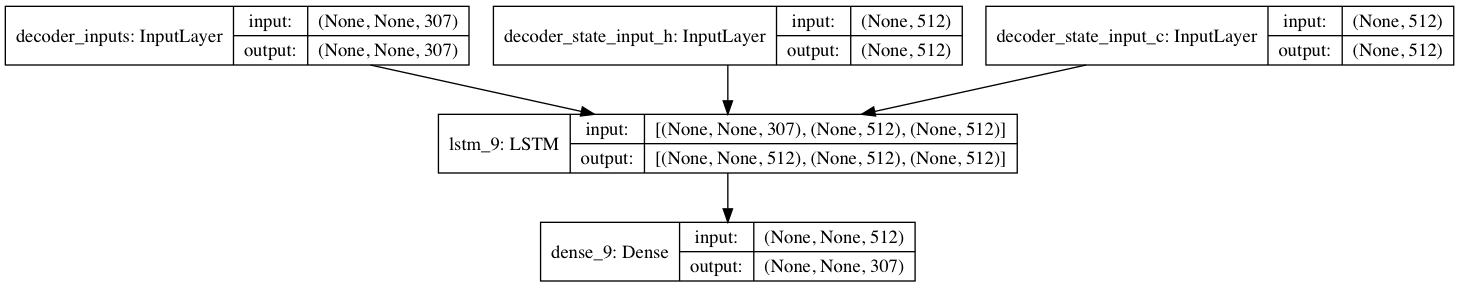

In [43]:
## Plot the inference Decoder model
plot_model(decoder_model, to_file='model_visualizations/inference_decoder_model.png', show_shapes=True)
Image(filename='inference_decoder_model.png') 


In [44]:
## Decode sequence using our two models

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    h0_ = states_value[0]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    #Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["**start**"]] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    
    decoded_sentence = ''
    while not stop_condition:
        #print(target_seq)
        output_tokens, h, c = decoder_model.predict(
        [target_seq] + states_value)
        
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token_prob = np.max(output_tokens[0, -1, :])
        sampled_char = reverse_target_token_index[sampled_token_index]
        
        # Exit condition: either hit max length
        # or find stop token.
        if (sampled_char == '**end**' or
            len(decoded_sentence.split()) > max_decoder_seq_length):
            stop_condition = True
        else: 
            decoded_sentence = decoded_sentence + ' ' + sampled_char
        

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    #Return h0_ for debugging
    return decoded_sentence, h0_


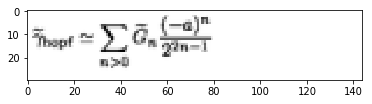

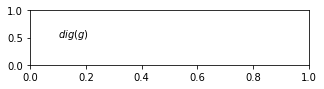

-
Target sentence: **start** \widetilde \gamma _ { \mathrm { h o p f } } \simeq \sum _ { n > 0 } \widetilde { G } _ { n } { \frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } } **end**
Decoded sentence:  d i g ( g )


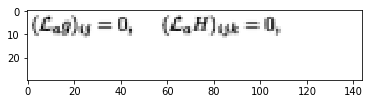

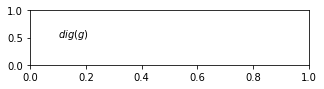

-
Target sentence: **start** ( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \ \ ( { \cal L } _ { a } H ) _ { i j k } = 0 , **end**
Decoded sentence:  d i g ( g )


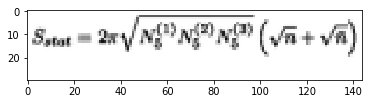

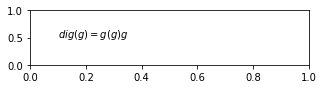

-
Target sentence: **start** S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ { ( 1 ) } N _ { 5 } ^ { ( 2 ) } N _ { 5 } ^ { ( 3 ) } } \left( \sqrt { n } + \sqrt { \bar { n } } \right) **end**
Decoded sentence:  d i g ( g ) = g ( g ) g


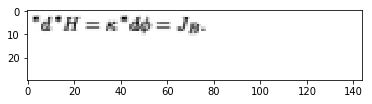

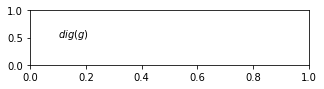

-
Target sentence: **start** \, ^ { * } d \, ^ { * } H = \kappa \, ^ { * } d \phi = J _ { B } . **end**
Decoded sentence:  d i g ( g )


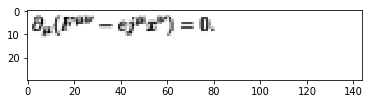

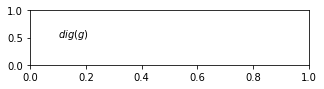

-
Target sentence: **start** \partial _ { \mu } ( F ^ { \mu \nu } - e j ^ { \mu } x ^ { \nu } ) = 0 . **end**
Decoded sentence:  d i g ( g )


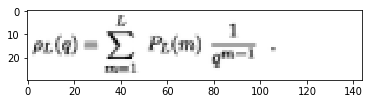

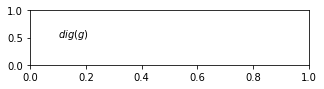

-
Target sentence: **start** \rho _ { L } ( q ) = \sum _ { m = 1 } ^ { L } \ P _ { L } ( m ) \ { \frac { 1 } { q ^ { m - 1 } } } \ \ . **end**
Decoded sentence:  d i g ( g )


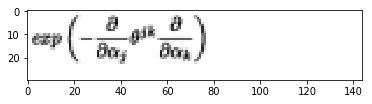

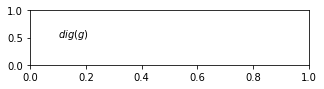

-
Target sentence: **start** e x p \left( - \frac { \partial } { \partial \alpha _ { j } } \theta ^ { j k } \frac { \partial } { \partial \alpha _ { k } } \right) **end**
Decoded sentence:  d i g ( g )


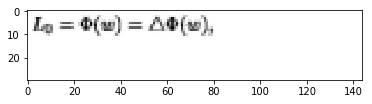

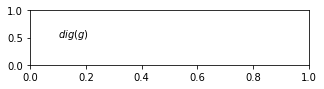

-
Target sentence: **start** L _ { 0 } = \Phi ( w ) = \bigtriangleup \Phi ( w ) , **end**
Decoded sentence:  d i g ( g )


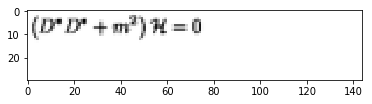

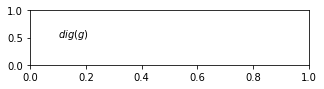

-
Target sentence: **start** \left( D ^ { * } D ^ { * } + m ^ { 2 } \right) { \cal H } = 0 **end**
Decoded sentence:  d i g ( g )


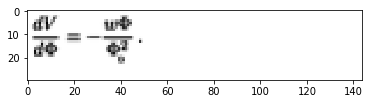

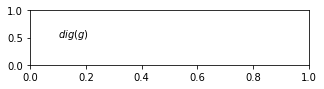

-
Target sentence: **start** { \frac { d V } { d \Phi } } = - { \frac { w \Phi } { \Phi _ { \! _ { 0 } } ^ { 2 } } } \, . **end**
Decoded sentence:  d i g ( g )


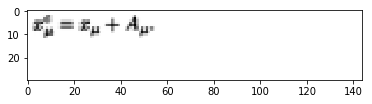

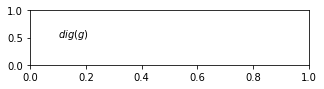

-
Target sentence: **start** x _ { \mu } ^ { c } = x _ { \mu } + A _ { \mu } . **end**
Decoded sentence:  d i g ( g )


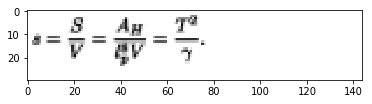

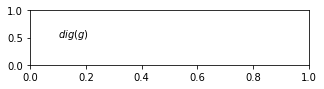

-
Target sentence: **start** s = { \frac { S } { V } } = { \frac { A _ { H } } { l _ { p } ^ { 8 } V } } = { \frac { T ^ { 2 } } { \gamma } } . **end**
Decoded sentence:  d i g ( g )


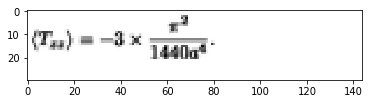

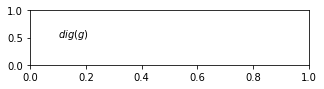

-
Target sentence: **start** \langle T _ { z z } \rangle = - 3 \times \frac { \pi ^ { 2 } } { 1 4 4 0 a ^ { 4 } } . **end**
Decoded sentence:  d i g ( g )


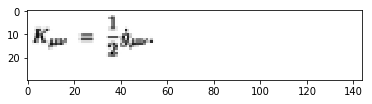

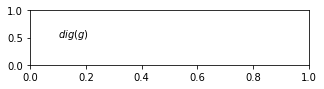

-
Target sentence: **start** K _ { \mu \nu } ~ = ~ \frac { 1 } { 2 } \dot { g } _ { \mu \nu } . **end**
Decoded sentence:  d i g ( g )


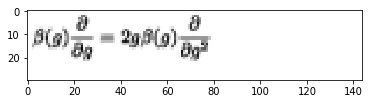

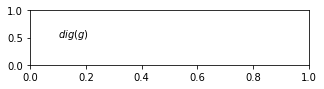

-
Target sentence: **start** \beta ( g ) \frac { \partial } { \partial g } = 2 g \beta ( g ) \frac { \partial } { \partial g ^ { 2 } } **end**
Decoded sentence:  d i g ( g )


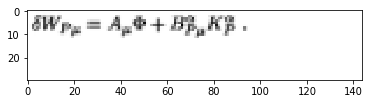

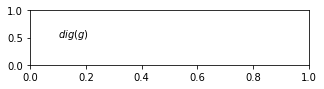

-
Target sentence: **start** \delta W _ { P \mu } = A _ { \mu } \Phi + B _ { P \mu } ^ { \alpha } K _ { P } ^ { \alpha } \ . **end**
Decoded sentence:  d i g ( g )


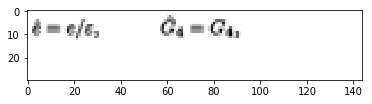

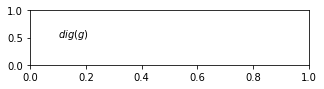

-
Target sentence: **start** \hat { e } = e / \varepsilon , \ \ \ \ \ \ \ \ \ \hat { G } _ { 4 } = G _ { 4 } , **end**
Decoded sentence:  d i g ( g )


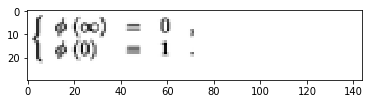

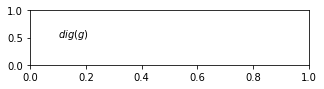

-
Target sentence: **start** \left\{ \begin{array} { l c l l } { \phi ~ ( \infty ) } & { = } & { 0 } & { , \vspace { 3 m m } } \\ { \phi ~ ( 0 ) } & { = } & { 1 } & { . } \\ \end{array} \right. **end**
Decoded sentence:  d i g ( g )


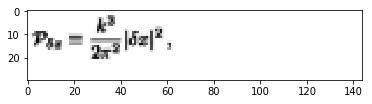

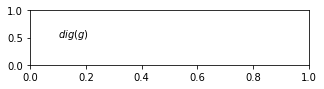

-
Target sentence: **start** { \cal P } _ { \delta x } \equiv { \frac { k ^ { 3 } } { 2 \pi ^ { 2 } } } | \delta x | ^ { 2 } \, , **end**
Decoded sentence:  d i g ( g )


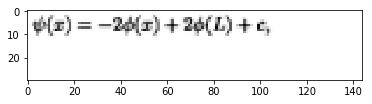

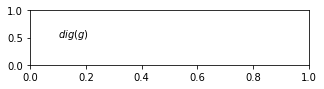

-
Target sentence: **start** \psi ( x ) = - 2 \phi ( x ) + 2 \phi ( L ) + c , **end**
Decoded sentence:  d i g ( g )


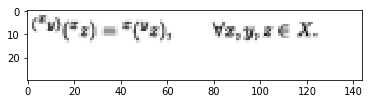

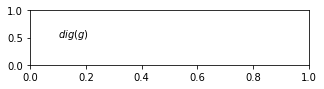

-
Target sentence: **start** { } ^ { ( { } ^ { \scriptstyle x } y ) } ( { } ^ { x } z ) = { } ^ { x } ( { } ^ { y } z ) , \qquad \forall x , y , z \in X . **end**
Decoded sentence:  d i g ( g )


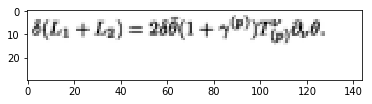

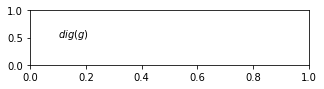

-
Target sentence: **start** \delta ( L _ { 1 } + L _ { 2 } ) = 2 \delta \bar { \theta } ( 1 + \gamma ^ { ( p ) } ) T _ { ( p ) } ^ { \nu } \partial _ { \nu } \theta . **end**
Decoded sentence:  d i g ( g )


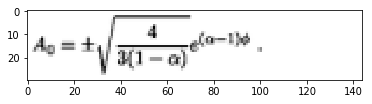

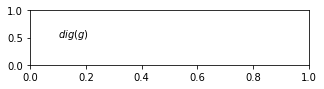

-
Target sentence: **start** A _ { 0 } = \pm \sqrt { { \frac { 4 } { 3 ( 1 - \alpha ) } } } e ^ { ( \alpha - 1 ) \phi } \ . **end**
Decoded sentence:  d i g ( g )


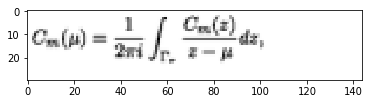

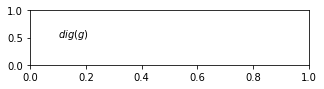

-
Target sentence: **start** C _ { m } ( \mu ) = { \frac { 1 } { 2 \pi i } } \int _ { \Gamma _ { r } } { \frac { C _ { m } ( z ) } { z - \mu } } d z , **end**
Decoded sentence:  d i g ( g )


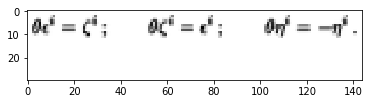

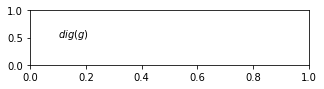

-
Target sentence: **start** \theta \epsilon ^ { i } = \zeta ^ { i } \, ; \qquad \theta \zeta ^ { i } = \epsilon ^ { i } \, ; \qquad \theta \eta ^ { i } = - \eta ^ { i } \, . **end**
Decoded sentence:  d i g ( g )


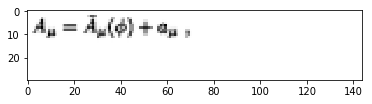

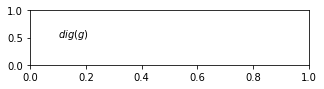

-
Target sentence: **start** A _ { \mu } = \bar { A } _ { \mu } ( \phi ) + a _ { \mu } \ , **end**
Decoded sentence:  d i g ( g )


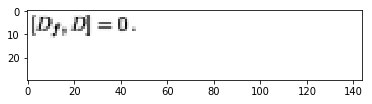

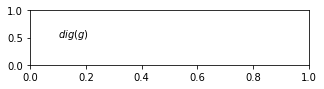

-
Target sentence: **start** \left[ D _ { f } , D \right] = 0 \, . **end**
Decoded sentence:  d i g ( g )


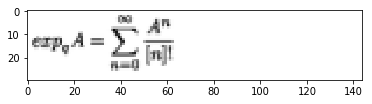

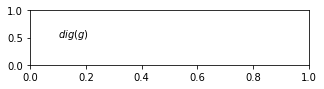

-
Target sentence: **start** \operatorname { e x p } _ { q } A = \sum _ { n = 0 } ^ { \infty } \frac { A ^ { n } } { [ n ] ! } **end**
Decoded sentence:  d i g ( g )


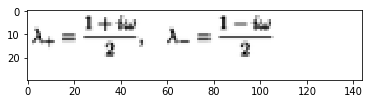

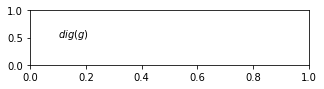

-
Target sentence: **start** \lambda _ { + } = \frac { 1 + i \omega } { 2 } , \quad \lambda _ { - } = \frac { 1 - i \omega } { 2 } **end**
Decoded sentence:  d i g ( g )


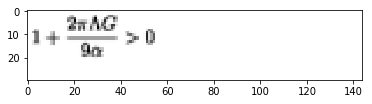

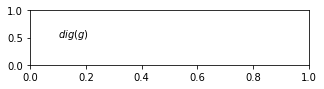

-
Target sentence: **start** 1 + \frac { 2 \pi \Lambda G } { 9 \alpha } > 0 **end**
Decoded sentence:  d i g ( g )


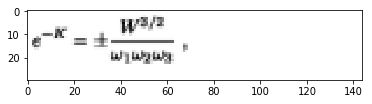

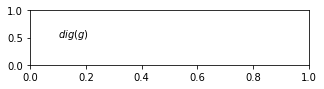

-
Target sentence: **start** e ^ { - K } = \pm \frac { W ^ { 3 / 2 } } { \omega _ { 1 } \omega _ { 2 } \omega _ { 3 } } \ , **end**
Decoded sentence:  d i g ( g )


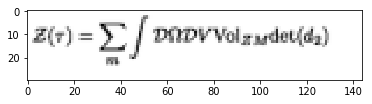

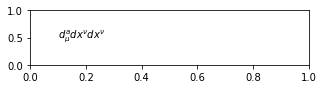

-
Target sentence: **start** { \cal { Z } } ( \tau { } ) = \sum _ { m } \int { \cal { D } } \Omega { \cal { D } } V { \mathrm { V o l } } _ { Z M } { \mathrm { d e t } } ( d _ { 2 } ) **end**
Decoded sentence:  d _ { \mu } ^ { a } d x ^ { \nu } d x ^ { \nu }


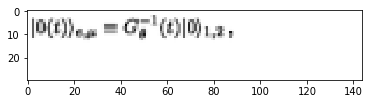

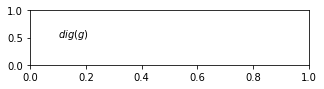

-
Target sentence: **start** | 0 ( t ) \rangle _ { e , \mu } \equiv G _ { \theta } ^ { - 1 } ( t ) | 0 \rangle _ { 1 , 2 } \, , **end**
Decoded sentence:  d i g ( g )


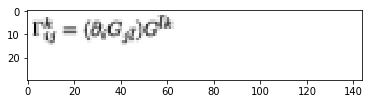

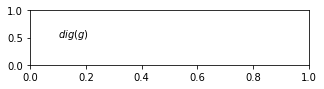

-
Target sentence: **start** \Gamma _ { i j } ^ { k } = ( \partial _ { i } G _ { j { \bar { l } } } ) G ^ { { \bar { l } } k } \, **end**
Decoded sentence:  d i g ( g )


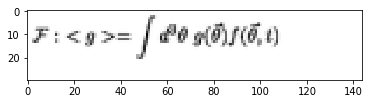

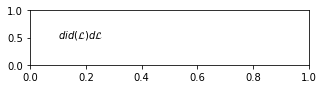

-
Target sentence: **start** { \cal { F } } : \ < g > = \int d ^ { 3 } \theta \ g ( { \vec { \theta } } ) f ( { \vec { \theta } } , t ) \, **end**
Decoded sentence:  d i d ( { \cal L } ) d { \cal { L } }


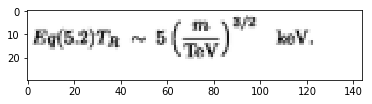

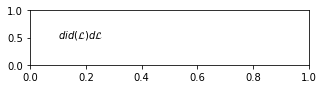

-
Target sentence: **start** E q ( 5 . 2 ) T _ { R } \; \sim \; 5 \left( \frac { m } { \mathrm { T e V } } \right) ^ { 3 / 2 } \; \; \; \mathrm { k e V } . **end**
Decoded sentence:  d i d ( { \cal L } ) d { \cal { L } }


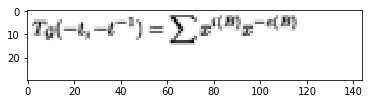

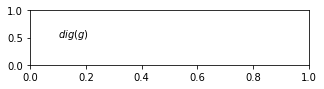

-
Target sentence: **start** T _ { { \cal G } } ( - t , - t ^ { - 1 } ) = \sum x ^ { i ( B ) } x ^ { - e ( B ) } **end**
Decoded sentence:  d i g ( g )


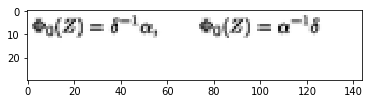

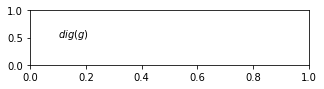

-
Target sentence: **start** \Phi _ { 0 } ( Z ) = \delta ^ { - 1 } \alpha , \qquad \Phi _ { 0 } ( Z ) = \alpha ^ { - 1 } \delta **end**
Decoded sentence:  d i g ( g )


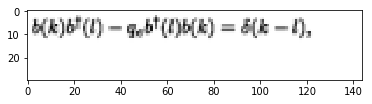

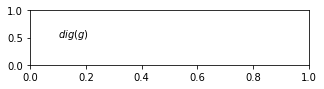

-
Target sentence: **start** b ( k ) b ^ { \dagger } ( l ) - q _ { e } b ^ { \dagger } ( l ) b ( k ) = \delta ( k - l ) , **end**
Decoded sentence:  d i g ( g )


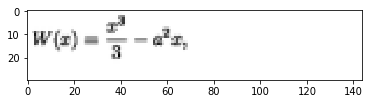

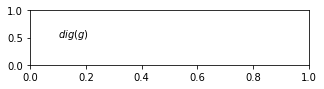

-
Target sentence: **start** W ( x ) = \frac { x ^ { 3 } } { 3 } - a ^ { 2 } x , **end**
Decoded sentence:  d i g ( g )


In [46]:
num_test = 40 # We're currently predicting on the train set

encoded_images = []

for seq_index in range(num_test):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]

    plt.imshow(np.squeeze(input_seq), cmap='gray')
    plt.show()
    
    decoded_sentence, h0_ = decode_sequence(input_seq)
    
    plt.text(0.1, 0.5, r"$%s$" % decoded_sentence, fontsize = 10)                                  

    #hide axes                                                                      
    fig = plt.gcf()
    fig.set_size_inches(5, 1)

    #fig.axes.get_xaxis().set_visible(False)                                         
    #fig.axes.get_yaxis().set_visible(False)  

    plt.draw() #or savefig                                                          
    plt.show()
   
    
    
    #encoded_images.append(h0_)
    
    
    print('-')
    print('Target sentence: ' + str(target_texts[seq_index]))
    print('Decoded sentence: ' + str(decoded_sentence))